In [1]:
#load/ remove duplicate column
import pandas as pd
import numpy as np
df=pd.read_json('data/News_Category_Dataset_V2.json', lines=True)
df['text']=df['headline']+' '+ df['short_description']
df['category']=df['category'].map(lambda x: 'WORLDPOST' if x=='THE WORLDPOST' else x)

#preprocessing
#basic cleaning (punctuation, capitalization, tokenization etc.
def basic_clean(text):
    cleaned=''.join([i.lower() for i in text if i.isalpha() or i == ' '])
    import re
    cleaned=re.sub(" +", ' ', cleaned)
    cleaned=cleaned.strip()
    cleaned=cleaned.split(' ')
    stop_words = ['a', 'an', 'the', 'for', 'in', 'it', 'its', 'on', 'at', 'they', 'them',
                  'their', 'theirs', 'that', 'what', 'which', 'has', 'have', 'had',
                  'having', 'thus', 'do', 'no', 'nor', 'not', 'is', 'are', 'was',
                  'were', 'be', 'been', 'being', 'did', 'in', 'out', 'both', 'each',
                  'few', 'he', 'she', 'him', 'her', 'these', 'those', 'but', 'if',
                  'of', 'after', 'before', 'up', 'down', 'over', 'under',
                  'again', 'then', 'there', 'some', 'such', 'other',
                  'only', 'same', 'so', 'than', 'and', 'to']
    cleaned=[i for i in cleaned if i not in stop_words]
    return cleaned

df['text']= df['text'].map(basic_clean)

#lemmaization
from nltk.stem import WordNetLemmatizer
def lem(text):
    wnl=WordNetLemmatizer()
    lemmed=[]
    for i in text:
        w1=wnl.lemmatize(i, 'v')
        w2=wnl.lemmatize(w1, 'a')
        w3=wnl.lemmatize(w2, 'n')
        lemmed.append(w3)
    return lemmed

df_cleaned=df.copy()
df_cleaned['text']= df_cleaned['text'].map(lem)

#vectorization-exploration phase
#count
from sklearn.feature_extraction.text import CountVectorizer
countVec=CountVectorizer()
text_CV= countVec.fit_transform(df_cleaned['text'].apply(lambda x: ' '.join(x)))
#countVec.vocabulary_
#countVec.get_feature_names


#tfidf
from sklearn.feature_extraction.text import TfidfTransformer
tfidfVec=TfidfTransformer()
text_tfidf= tfidfVec.fit_transform(text_CV)


#stop words MI
from sklearn.feature_selection import mutual_info_classif
valuableSWords=['how', 'however', 'against', 'further', 'myself', 'whom',
                'once', 'you', 'yourself', 'why', 'during', 'while', 'same',
                'more', 'least', 'so', 'now', 'further', 'farther', 'others']


swMI=mutual_info_classif(text_CV[:, [countVec.vocabulary_[i] for i in valuableSWords]],
                    y=df_cleaned['category'])



normaltermsMI=mutual_info_classif(text_CV[:,np.random.randint(0, text_CV.shape[1], 5) ],
                    y=df_cleaned['category'])

MImatrix=mutual_info_classif(text_CV[:,np.random.randint(0, text_CV.shape[1], 100) ],
                             y=df_cleaned['category'])


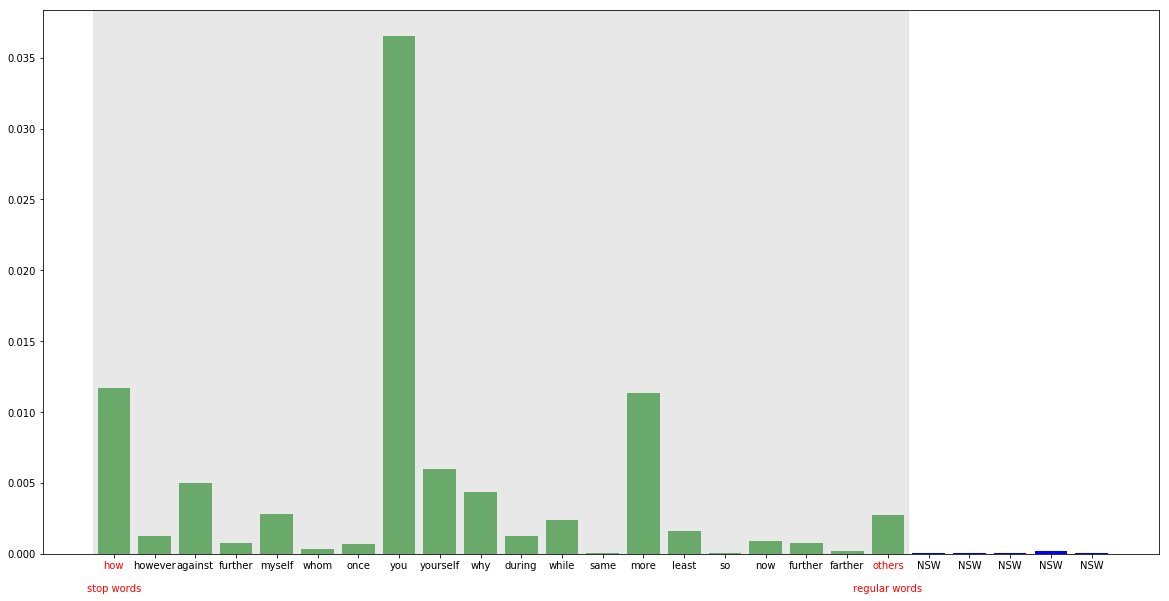

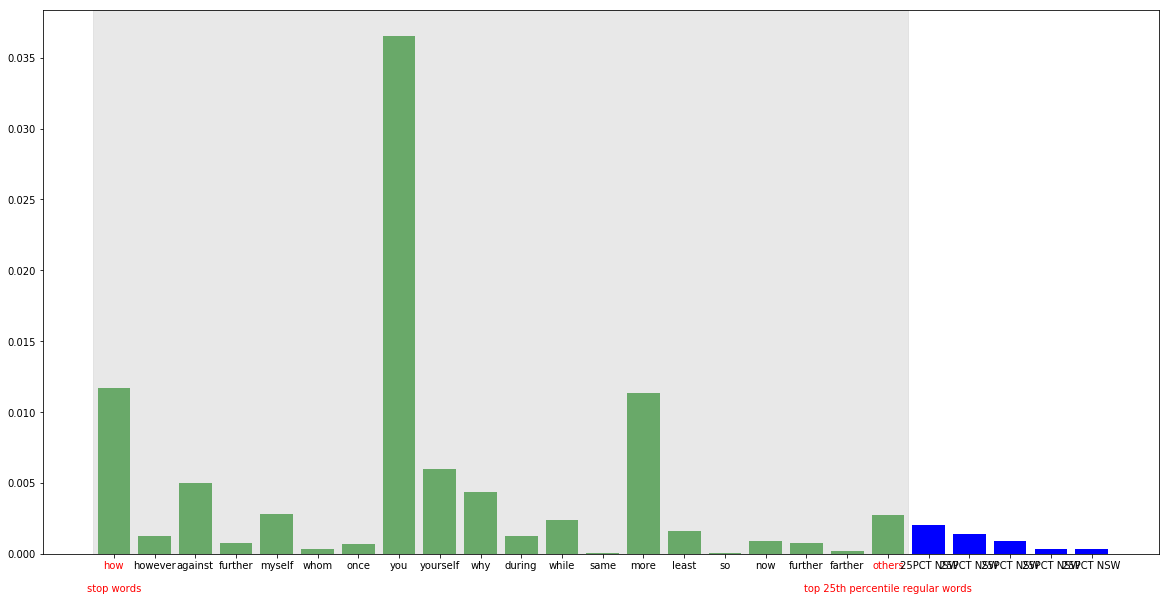

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.bar(np.arange(25), np.append(swMI, normaltermsMI), color=
['green' for i in range(20)]+ ['blue' for i in range (5)])
plt.xticks(np.arange(25), [valuableSWords[0]+'\n\nstop words']+valuableSWords[1:-1]+
[valuableSWords[-1]+'\n\nregular words']+ ['NSW' for i in range(5)])
plt.gca().get_xticklabels()[0].set_color('red')
plt.gca().get_xticklabels()[19].set_color('red')
plt.axvspan(-0.5,19.5, color='lightgray', alpha=0.5)
plt.show()



plt.figure(figsize=(20,10))
plt.bar(np.arange(25), np.append(swMI, MImatrix[np.argsort(MImatrix)[::-1][0:5]]),
        color=
['green' for i in range(20)]+ ['blue' for i in range (5)])
plt.xticks(np.arange(25), [valuableSWords[0]+'\n\nstop words']+valuableSWords[1:-1]+
[valuableSWords[-1]+'\n\ntop 25th percentile regular words']+
           ['25PCT NSW' for i in range(5)])
plt.gca().get_xticklabels()[0].set_color('red')
plt.gca().get_xticklabels()[19].set_color('red')
plt.axvspan(-0.5,19.5, color='lightgray', alpha=0.5)
plt.show()

In [6]:
#metadata features
from textblob import TextBlob
Polarity=[]
Subjectivity=[]
countLen=[]


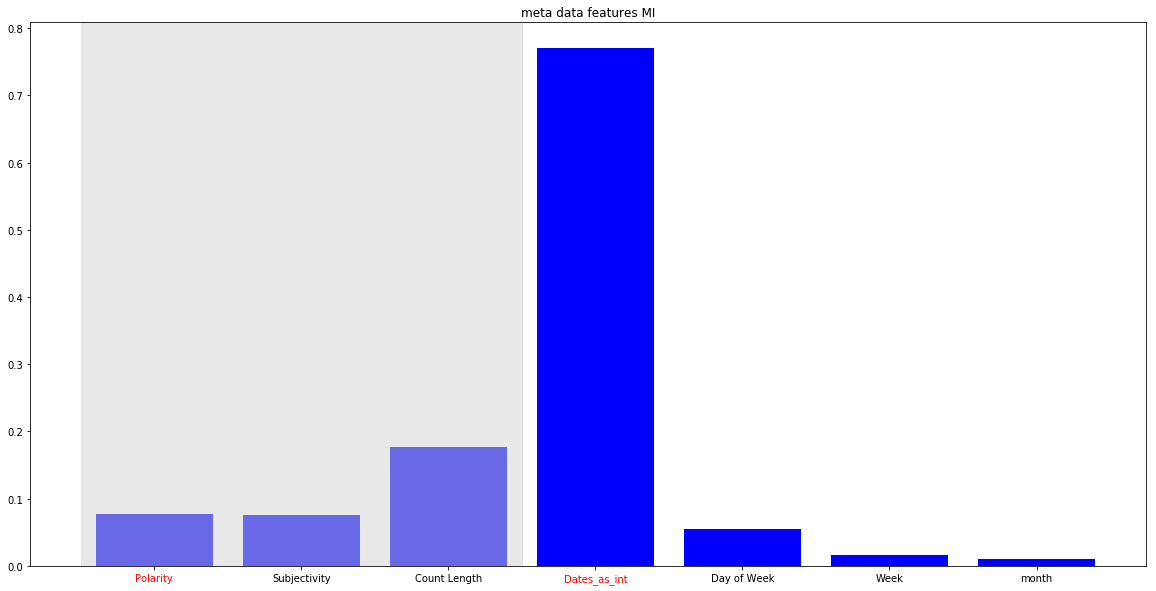

In [7]:
for i in range(len(df['text'])):
    x=TextBlob(" ".join(df['text'][i])).sentiment
    Polarity.append(x[0])
    Subjectivity.append(x[1])
    countLen.append(len(df['text'][i]))


dates_int=[(df['date'][i]-df['date'].min()).components[0] for i in range(len(df))]
dates_days=df['date'].apply(lambda x: x.dayofweek)
dates_week=df['date'].apply(lambda x: x.week)
dates_month=df['date'].apply(lambda x: x.month)
daysMI=mutual_info_classif(np.array([dates_int,dates_days,dates_week,dates_month]).T,
                    df_cleaned['category'])

metafeaturesMI=mutual_info_classif(np.array([Polarity, Subjectivity, countLen]).T,
                                   df_cleaned['category'])

#meta features
plt.figure(figsize=(20,10))
plt.bar(np.arange(7), np.append(metafeaturesMI, daysMI),
        color= 'blue')
plt.xticks(np.arange(7), ['Polarity', 'Subjectivity', 'Count Length',
                          'Dates_as_int','Day of Week', 'Week', 'month' ])
plt.gca().get_xticklabels()[0].set_color('red')
plt.gca().get_xticklabels()[3].set_color('red')
plt.title('meta data features MI')
plt.axvspan(-0.5, 2.5, color='lightgray', alpha=0.5)
plt.show()


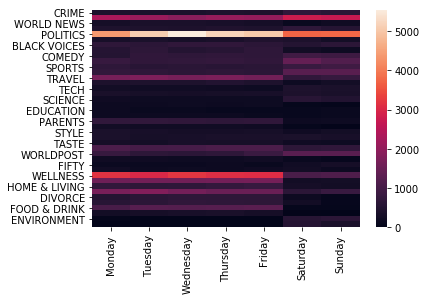

In [8]:
#days of week hist
import seaborn as sb
import calendar
days=list(calendar.day_name)
dict4Days={}
for i in range(7):
    counts=[]
    day = days[i]
    mask = dates_days[dates_days == i].index
    forThatDay = df_cleaned['category'][mask]
    for j in df_cleaned['category'].unique():
        forThatCat=forThatDay[forThatDay==j].count()
        counts.append(forThatCat)
    dict4Days[day]=counts
heatmapDF=pd.DataFrame(dict4Days)
heatmapDF.index=[i for i in df_cleaned['category'].unique()]

sb.heatmap(heatmapDF)
plt.show()


In [9]:
#glove
gloveEmbeddings={}
with open('glove.twitter.27B.50d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        vals=line.split()
        word=vals[0]
        vector=np.asarray(vals[1:])
        gloveEmbeddings[word]=vector


FileNotFoundError: [Errno 2] No such file or directory: 'glove.twitter.27B.50d.txt'

In [ ]:
#representative words for each class based on tfidf
topTerms={}
topTermsIndex={}
for i in df_cleaned['category']:
    x=np.sum(text_tfidf[df_cleaned['category']==i,: ], axis=0)
    x=np.array(x).flatten()
    x=np.argsort(x)[::-1]
    top3=x[:3].tolist()
    top3words=[countVec.get_feature_names()[j] for j in top3]
    topTerms[i]=top3words
    topTermsIndex[i]=top3


#crime- police, shoot, kill; world news- korea, north; politics- trump, donald
#black voices- black, police; comedy-trump; sports-nfl; tech-apple, google
# religion- pope, meditation; green-climate, change; worldpost- kill, attack
#taste-recipe; education- school, teacher


#representative words glove vecs
repwordGlove=np.ones(50)
for i in ['police', 'shoot', 'kill', 'korea', 'north', 'trump', 'donald',
          'black', 'cops', 'president', 'nfl', 'apple', 'google', 'pope',
          'meditation', 'climate', 'kill', 'recipe', 'school', 'teacher']:
    x=gloveEmbeddings[i]
    repwordGlove=np.vstack((repwordGlove, x))

repwordGlove=repwordGlove[1:]

#t-sne representation
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2)
reducedrep=tsne.fit_transform(repwordGlove)

#top terms
tsneWords=['police', 'shoot', 'kill', 'korea', 'north', 'trump', 'donald',
          'black', 'cops', 'president', 'nfl', 'apple', 'google', 'pope',
          'meditation', 'climate', 'kill', 'recipe', 'school', 'teacher']

#scatter
tsneVIZ=pd.DataFrame(reducedrep, columns=['x', 'y'])
tsneVIZ['categories']=pd.Series(['Crime', 'Crime', 'Crime', 'World News',
                                 'World News', 'politics', 'politics', 'black voices',
                                 'black voices', 'comedy', 'sport', 'tech', 'tech',
                                 'religion', 'religion', 'green',  'worldpost',
                                 'taste', 'education', 'education'])

sb.scatterplot(data=tsneVIZ, x='x', y='y', hue='categories')
for i,j in zip(reducedrep, tsneWords):
    plt.annotate(j, (i[0], i[1]))
plt.title('GloVe embeddings reduced to 2 dimensions with T-SNE')
plt.legend(bbox_to_anchor=(1.01,1), borderaxespad= 0)
plt.show()



#glove transform
gloveTransform=np.ones(50)
for i in df_cleaned['text']:
    vec=np.ones(50)
    for j in i:
        try:
            x=gloveEmbeddings[j]
            vec=np.vstack((vec, x))
        except:
            pass
    vec=vec[1:]
    vec=np.mean(vec, axis=0)
    gloveTransform=np.vstack((gloveTransform, vec))
gloveTransform=gloveTransform[1:]

